# Trabajo Segunda Evaluación: Clasificación de imagenes con Redes Neurales y Keras

## Autores: Cristian Cabrera Pinto y Alex

Trabajo de la Asignatura PIA

- Importación de paquetes

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from tensorflow import keras

- Una nueva libreria que se ha tenido que instalar para el correcto funcionamiento de esta práctica ha sido OpenCv (import cv2). Esta librería no se ha visto en clase anteriormente, pero es un estándar de la industria para el Computer Vision.

**¿Qué hace y por qué la usamos?**
1.  **Lectura eficiente:** Permite cargar imágenes desde el disco de forma muy rápida convirtiéndolas en matrices numéricas (arrays de NumPy).
2.  **Gestión de Canales:** A diferencia de otras librerías que leen en formato RGB (Rojo, Verde, Azul), OpenCV lee por defecto en formato **BGR** (Azul, Verde, Rojo). Por eso, en el código verán una función `cv2.cvtColor` para convertir las imágenes a RGB antes de pasarlas a la red neuronal.
3.  **Procesamiento:** Nos facilita el redimensionamiento (`resize`) de las imágenes para asegurar que todas tengan el tamaño solicitado de 150x150 píxeles.


### 1. Carga de datos

In [23]:
# Rutas de las imagenes
TRAIN_DIR = './seg_train/seg_train'
TEST_DIR = './seg_test/seg_test'
PRED_DIR = './seg_pred/seg_pred'

# Clases de las imagenes
CLASSES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Dimension de las imagenes
IMG_SIZE = 150

# Función que carga las imagenes dado un directorio y las etiquetas
def cargar_imagenes(directorio):
    datos =  []
    etiquetas = []
    
    #Recorremos cada carpeta de cada clase
    for indice_etiqueta, nombre_etiqueta in enumerate(CLASSES):
        path = os.path.join(directorio, nombre_etiqueta) #Obtenemos el path de cada clase (carpeta con el nombre de la clase)
        
        
        #Listamos las imagenes que hay en cada carpeta y las cargamos
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img) #Obtenemos el path de cada imagen
                
                #Usamos OpenCV para cargar la imagen, convertirla a RGB y redimensionarla
                #Leemos la imagen con cv2.imread
                img_array = cv2.imread(img_path)
                #Convertimos la imagen de BGR a RGB con cv2.cvtColor
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                #Redimensionamos la imagen a las dimensiones especificadas con cv2.resize (Por seguridad, aunque las imagenes ya estan redimensionadas a 150x150, por si acaso)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                
                datos.append(img_array) #Agregamos la imagen a la lista de datos
                etiquetas.append(indice_etiqueta) #Agregamos la etiqueta (indice de la clase) a la lista de etiquetas
                
            except Exception as e:
                print(f'Error al cargar la imagen {img}: {e}')
                pass
    return np.array(datos), np.array(etiquetas)

#Cargar los datos de entrenamiento y test
X_train, y_train = cargar_imagenes(TRAIN_DIR)
X_test, y_test = cargar_imagenes(TEST_DIR)

#Dimensiones de los datos
print(f'Dimensiones de X_train: {X_train.shape}')
print(f'Dimensiones de y_train: {y_train.shape}')
print(f'Dimensiones de X_test: {X_test.shape}')
print(f'Dimensiones de y_test: {y_test.shape}')

Dimensiones de X_train: (14034, 150, 150, 3)
Dimensiones de y_train: (14034,)
Dimensiones de X_test: (3000, 150, 150, 3)
Dimensiones de y_test: (3000,)


In [24]:
X_train

array([[[[247, 247, 245],
         [247, 247, 245],
         [248, 248, 246],
         ...,
         [248, 248, 248],
         [247, 247, 245],
         [247, 247, 245]],

        [[246, 246, 244],
         [247, 247, 245],
         [247, 247, 245],
         ...,
         [248, 248, 248],
         [247, 247, 245],
         [247, 247, 245]],

        [[246, 246, 244],
         [246, 246, 244],
         [247, 247, 245],
         ...,
         [248, 248, 248],
         [247, 247, 245],
         [247, 247, 245]],

        ...,

        [[ 47,  46,  44],
         [ 62,  61,  59],
         [ 49,  48,  46],
         ...,
         [ 51,  46,  43],
         [ 45,  40,  37],
         [ 94,  89,  86]],

        [[ 77,  76,  74],
         [ 47,  46,  44],
         [ 43,  42,  40],
         ...,
         [ 22,  17,  14],
         [ 55,  50,  47],
         [ 39,  34,  31]],

        [[ 59,  58,  56],
         [ 55,  54,  52],
         [ 60,  59,  57],
         ...,
         [ 31,  26,  23],
        

In [25]:
y_train

array([0, 0, 0, ..., 5, 5, 5])

Tras la carga de datos utilizando la librería **OpenCV**, hemos obtenido las siguientes dimensiones en nuestros tensores de datos, las cuales confirman que el proceso de lectura ha sido correcto:

* **Conjunto de Entrenamiento (`X_train`):** Consta de **14.034 imágenes**.
* **Conjunto de Test (`X_test`):** Consta de **3.000 imágenes**.

**Análisis de la forma (Shape): `(150, 150, 3)`**
Cada imagen se representa como una matriz tridimensional con la estructura:
1.  **Altura:** 150 píxeles.
2.  **Anchura:** 150 píxeles.
3.  **Canales:** 3 canales de color (RGB). Al haber utilizado `cv2.cvtColor`, hemos asegurado que los canales estén en orden Rojo-Verde-Azul, en lugar del estándar BGR por defecto de OpenCV.

Las etiquetas (`y_train`, `y_test`) corresponden a vectores unidimensionales que contienen el índice de la clase (0 a 5) para cada imagen.

### 2. Visualización de un subconjunto de imagenes

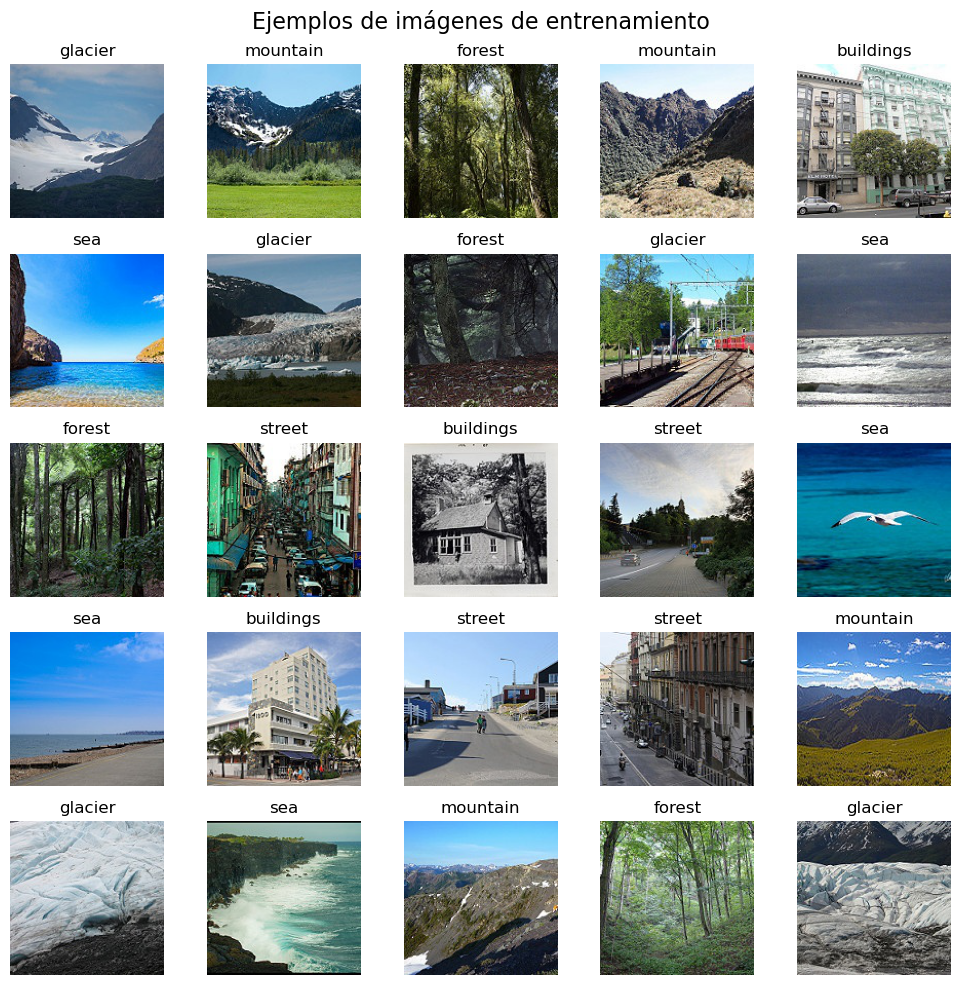

In [26]:
plt.figure(figsize=(10, 10))

#Cogemos indices aleatorios de las imagenes de entrenamiento
indices_aleatorios = np.random.choice(len(X_train), size=25, replace=False)

for i, indice in enumerate(indices_aleatorios):
    plt.subplot(5, 5, i + 1) #Creamos una cuadrícula de 5x5 para mostrar las imagenes
    plt.imshow(X_train[indice]) #Mostramos la imagen correspondiente al indice aleatorio
    plt.title(CLASSES[y_train[indice]]) #Mostramos el nombre de la clase correspondiente a la etiqueta de la imagen
    plt.axis('off') #Ocultamos los ejes
    
plt.suptitle('Ejemplos de imágenes de entrenamiento', fontsize=16) #Título general para la figura
plt.tight_layout() #Ajustamos el layout para que las imagenes no se superpongan
plt.show()

In [27]:
# Descripción de los valores de los píxeles (Requisito explícito del enunciado)
print("--- Análisis de valores de píxeles ---")
print(f"Valor MÁXIMO del pixel en el dataset: {np.max(X_train)}")
print(f"Valor MÍNIMO del pixel en el dataset: {np.min(X_train)}")

# Nota: Al usar OpenCV, los datos suelen ser uint8 (0-255). 
# Verificamos el tipo de dato.
print(f"Tipo de dato actual: {X_train.dtype}")

--- Análisis de valores de píxeles ---
Valor MÁXIMO del pixel en el dataset: 255
Valor MÍNIMO del pixel en el dataset: 0
Tipo de dato actual: uint8


### 3.División del conjunto de datos

In [28]:
## Division de los datos en entrenamiento y validación
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [29]:
X_test.shape

(3000, 150, 150, 3)

### 4. Creación de la arquitectura de la Red Neuronal

In [30]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [31]:
network = models.Sequential()

network.add(layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3))) #Aplanamos las imagenes de 150x150x3 a un vector de 67500 elementos
network.add(layers.Dense(512,activation="relu"))    
network.add(layers.Dense(256,activation="relu"))
network.add(layers.Dense(128,activation="relu"))
network.add(layers.Dense(6, activation="softmax"))

c:\Users\IABD\anaconda3\envs\piaentorno\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
network.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,725,510 (132.47 MB)

 Trainable params: 34,725,510 (132.47 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Escalado y vectorización

In [33]:
# Escalado de entrenamiento
X_train_prep = X_train.astype('float32') / 255

# Escalado de test
X_test_prep = X_test.astype('float32') / 255

X_val_prep = X_val.astype('float32') / 255


# Comprobación de dimensiones (Ahora deberían ser 150, 150, 3)
print(f"X_train_prep shape: {X_train_prep.shape}")

X_train_prep shape: (11227, 150, 150, 3)


In [34]:
X_train.shape

(11227, 150, 150, 3)

In [35]:
X_train_prep.shape

(11227, 150, 150, 3)

In [36]:
from tensorflow.keras.utils import to_categorical

y_train_prep = to_categorical(y_train)
y_test_prep = to_categorical(y_test)
y_val_prep = to_categorical(y_val)

In [37]:
y_train

array([0, 4, 2, ..., 1, 0, 4])

In [38]:
y_train_prep

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

### 5. Entrenamiento de la Red Neuronal

In [39]:
network.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [40]:
# Entrenamos
# Usamos el 20% de los datos de entrenamiento para validar en cada época
history = network.fit(X_train_prep, y_train_prep, 
                    epochs=15, 
                    batch_size=64, 
                    validation_data=(X_val_prep, y_val_prep))

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 235ms/step - accuracy: 0.3663 - loss: 5.5216 - val_accuracy: 0.3506 - val_loss: 1.7475
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.4773 - loss: 1.4442 - val_accuracy: 0.4521 - val_loss: 1.4284
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.5076 - loss: 1.3133 - val_accuracy: 0.4955 - val_loss: 1.3162
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.5492 - loss: 1.2170 - val_accuracy: 0.5198 - val_loss: 1.2682
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.5583 - loss: 1.1915 - val_accuracy: 0.5397 - val_loss: 1.2498
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.5705 - loss: 1.1507 - val_accuracy: 0.4642 - val_loss: 1.3655
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.5725 - loss: 1.1245 - val_accuracy: 0.5422 - val_loss: 1.2637
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.6022 - loss: 1

### 6. Informe del modelo

### 7. Realizar predicción con imagenes de prueba

### 8. Realizar una evaluación de test, Accuracy, Matriz de confusi´on, Precisi´on, Recall y F1-score

### 9.Realizar una evaluaci´on del overfitting, junto unas gr´aficas donde se aprecie queno hay overfitting